## what is positional encoding

> it is a layer which gives positional encoding vectors to a word according to its position in the sentence

> transformers do not take word order to account

> position/order of words is very important in the world of languages " is cat on table the " does not give sense right !

> so to make the model consider the words position order ,something must be explicitly done

### positional embedding VS encoding

positional embedding is a embeding layer , so.. usually embedding layer assigns unique  d dimensional vectors for a each word in the vocabulary similarly positional embeding will also assign some vectors to each position till the length of the longest sentence int the corpus by training

positional encoding are completly different they do not learn while training and they can handle sentence of unknown lenght to

#### Why they are not in rnn/gru/lstm

positional embeddings are not needed in those reccurent architectures because input arefeedee to them in a time sequence so they defaultly learn how to handle seuences in a time based manner 

but for attention models the input are fed at a time to decrease time complexity and the processing of nth word should not wait untill n-1 words and they learn relationship between a word with each and other word with a sentece so they are able to deal the words context perfectly (context of a word depends on its surrounding words

#### how do they work ?

They create vectors by sinusoidal function (sinusoidal fn are similar to alternating bits)





In [3]:
import numpy as np
from matplotlib import pyplot as plt

The formula used to calculate encodings

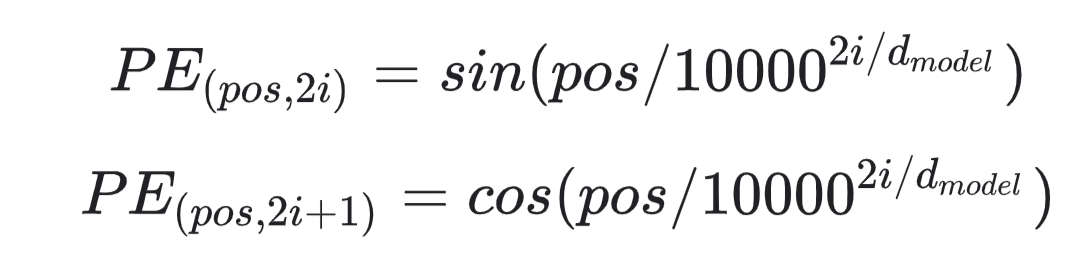

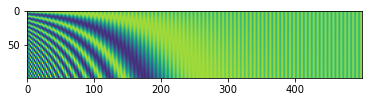

In [34]:
class Positional_encoding():
    def __init__(self,dim):
        self.d=dim
    def get_enc_vec(self,pos,i):
        d=self.d
        # according to th formula if it is 2i(even) 2i is used else 2i+1(odd) 2i is used (-1) is done
        k= i if i%2==0 else i-1
        if(i%2==0):
            return np.sin(pos/(10000**(k/d)))
        else: 
            return np.cos(pos/(10000**(k/d)))
        
    def create_encoding(self,seq_len):
        
        enc_mat=np.zeros((seq_len,self.d))# each word in the sentence will have a d dimensional vector according to its postion
        for pos in range(seq_len):
            for i in range(self.d):
                enc_mat[pos,i]=self.get_enc_vec(pos,i)
        plt.imshow(enc_mat)
        return enc_mat
    
    def forward(self,courpus):
        
        seq_len=max([len(i) for i in corpus])# find the maximum seq len among all batches
        enc_mat =self.create_encoding(seq_len)
        return enc_mat
p=Positional_encoding(500)
z=p.create_encoding(100)

since it returns alternating vectors of sin and cosine , dimension must be even 
and equal to embedding layer


_______________________________________________________________________________________________________________________________

# Layer Normalization

Layer Normalization the normalization happens across the axes within each example, rather than across different examples in the batch.

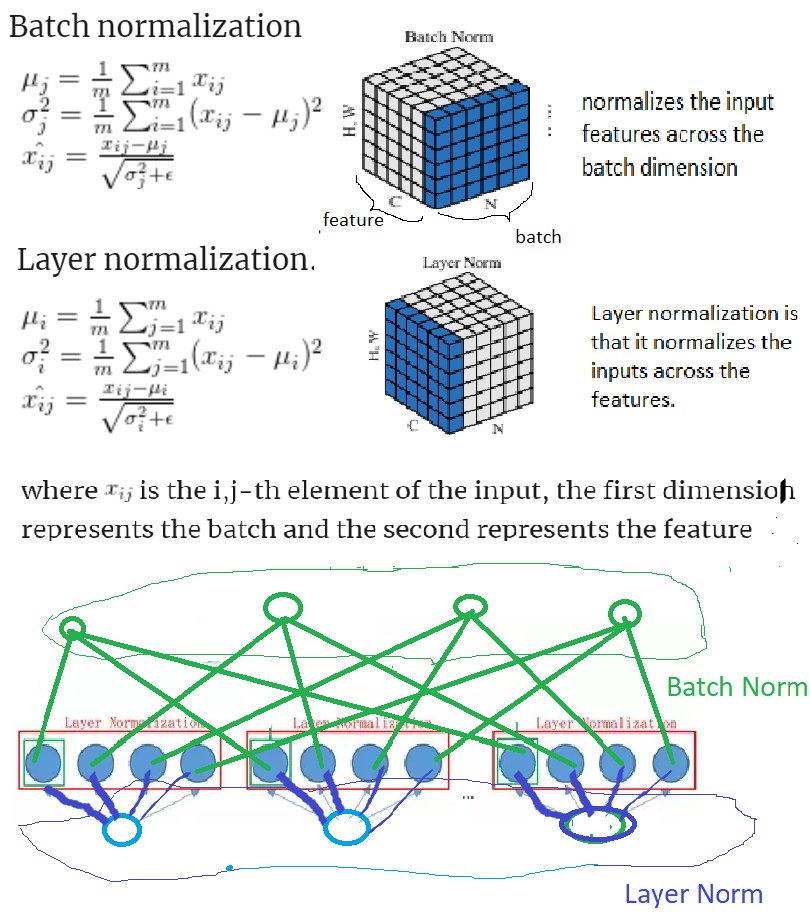

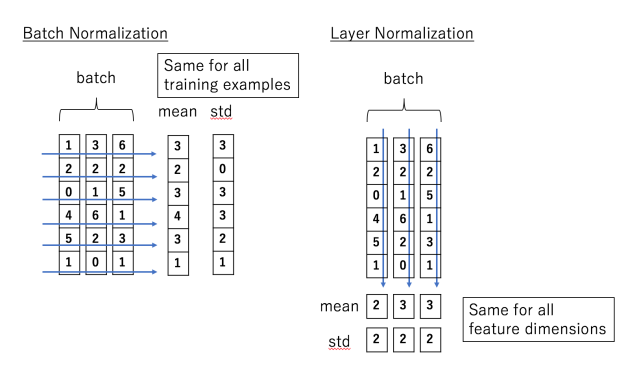

We cannot use batch normalization because each sentence is of each lengh we cannot compute across the batches so using layer norm calculates across the features independent of other batches so it also gives advantage of using low batch size for computing





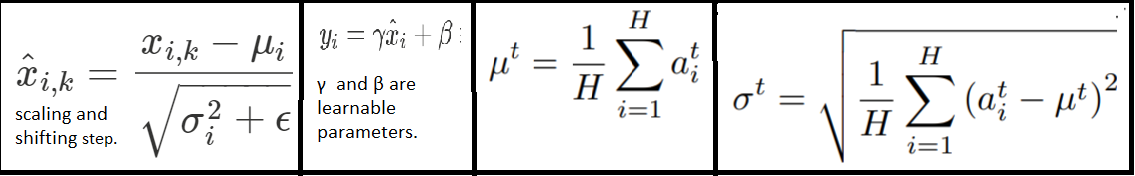


so these are the formula we will be implementing

In [39]:
class LayerNormalization():
    def __init__(self,axis=-1):
        self.axis=axis
        self.e=0.001 #epsilon
        self.alpha=1
        self.beta=0
        self.momentum=0.99
    def __call__(self,data):
        # we have to normalize the data across hidden units  so that standardizes the inputs to a layer helping to converge easily and fastly
        
        self.H=data.shape[-1]# the hidden unit dimension
        self.mean=np.sum(data,axis=-1,keepdims=True)/self.H
        a=data.copy()           
        self.Z=a-self.mean
        
        var=(self.Z)**2
        self.var=np.sum(var,axis=-1,keepdims=True)/self.H            
                
        num=(self.Z)
        den=np.sqrt(self.var+self.e)
        
        self.A=num/(den) # let A be the utput       
        Y=self.alpha*self.A+self.beta
        
        return Y
        
        
    def backward(self,err,lr):
        
        d_alpha=self.A*err
        d_alpha=np.sum(d_alpha.reshape(-1))
        d_beta=np.sum(err.reshape(-1))
        d_A=err*self.alpha
        
        dA_dx1=1/(np.sqrt(self.var+self.e))
        dA_dmean1=-1/(np.sqrt(self.var+self.e))
        
        dA_dvar=-0.5*self.Z*((self.var+self.e)**(-(3/2)))*1
                
        dvar_dx=(2*self.Z)/self.H
        dvar_dmean=(-2*self.Z)/self.H
        
        dmean_dx=1/self.H
        
        d_var=np.sum(d_A*dA_dvar,axis=-1,keepdims=True)
        d_mean=np.sum(d_A*dA_dmean1,axis=-1,keepdims=True)+np.sum(d_var*dvar_dmean,axis=-1,keepdims=True)
        
        d_x   =d_A*dA_dx1+d_var*dvar_dx+d_mean*dmean_dx
       
        
        self.alpha-=d_alpha*lr
        self.beta-=d_beta*lr
        
        return d_x
       
        
       
    
        
        
        
        
      
        
        
        

In [ ]:
class LayerNormalization():
    def __init__(self,axis=-1):
        self.axis=axis
        self.e=0.001 #epsilon
        self.alpha=1
        self.beta=0
        self.momentum=0.99
    def forward(self,x):
        y,cache=forward_batch(x,self.alpha,self.beta,self.e)
        self.C=cache
        return y
    def backward(self,err,lr):
        
        derr,a,b=backward_batch(err,self.C,self.alpha)
        self.alpha-=(a*lr*0.000001)
        self.beta-=(b*lr*0.000001)
        return derr
        
    
def forward_batch(x,a,b,e):
   # Mean of the mini-batch, mu
    mu = np.mean(x, axis=-1,keepdims=True)

   # Variance of the mini-batch, sigma^2
    var = np.var(x, axis=-1,keepdims=True)
    std_inv = 1.0 / np.sqrt(var + e)

   # The normalized input, x_hat
    x_hat = (x - mu) * std_inv
     
    y = a * x_hat + b

    cache = ( std_inv, x_hat)

    return y, cache
        
def backward_batch(dy, backprop_stuff,alpha):
   
    std_inv, x_hat = backprop_stuff
   
    dx_hat = dy * alpha
    dx = std_inv * (dx_hat - np.mean(dx_hat, axis=-1,keepdims=True) - x_hat * np.mean(dx_hat * x_hat, axis=-1,keepdims=True))
    """print(np.sum(abs(std_inv.reshape(-1)))) 
   print(np.sum(abs(((dx_hat - np.mean(dx_hat, axis=-1,keepdims=True) - x_hat)).reshape(-1)))) 
   print(np.sum(abs((np.mean(dx_hat * x_hat, axis=-1,keepdims=True)).reshape(-1)))) 
   print(np.sum(abs(dx.reshape(-1)))) """
   #dx=dx(4/dy.shape[-1])
    dalpha = np.sum((dy * x_hat).reshape(-1))
    dbeta = np.sum(dy.reshape(-1))
    
    
    
    return dx, dalpha, dbeta        
        

In [42]:
norm=LayerNormalization(axis=-1)
#data=np.random.randint(low=1,high=10,size=(2,2,4))
d=[[[6.6, 5, 2, 3],
  [8, 5, 7.2 ,8]],

 [[9, 4, 7, 9],
  [5, 9, 7.9 ,1]]]
data=np.array((d))
print(data.shape)
z=norm(data)
c=norm.backward(data,1)
print(c)

(2, 2, 4)
[[[ 4.34395700e-04  1.50708712e-04 -3.81204389e-04 -2.03900022e-04]
  [ 5.12749958e-04 -1.10646044e-03  8.09605197e-05  5.12749958e-04]]

 [[ 2.04150416e-04 -3.79136487e-04 -2.91643451e-05  2.04150416e-04]
  [-2.44587501e-05  1.10486078e-04  7.33762502e-05 -1.59403578e-04]]]


In [34]:
norm=LayerNormalization(axis=-1)
#data=np.random.randint(low=1,high=10,size=(2,2,4))
d=[[[6.6, 5, 2, 3],
  [8, 5, 7.2 ,8]],

 [[9, 4, 7, 9],
  [5, 9, 7.9 ,1]]]
data=np.array((d))
norm(data)

array([[[ 1.37638277,  0.47752055, -1.20784611, -0.64605722],
        [ 0.77348331, -1.66909557,  0.12212894,  0.77348331]],

       [[ 0.85508402, -1.58801317, -0.12215486,  0.85508402],
        [-0.23426285,  1.05822184,  0.70278855, -1.52674755]]])

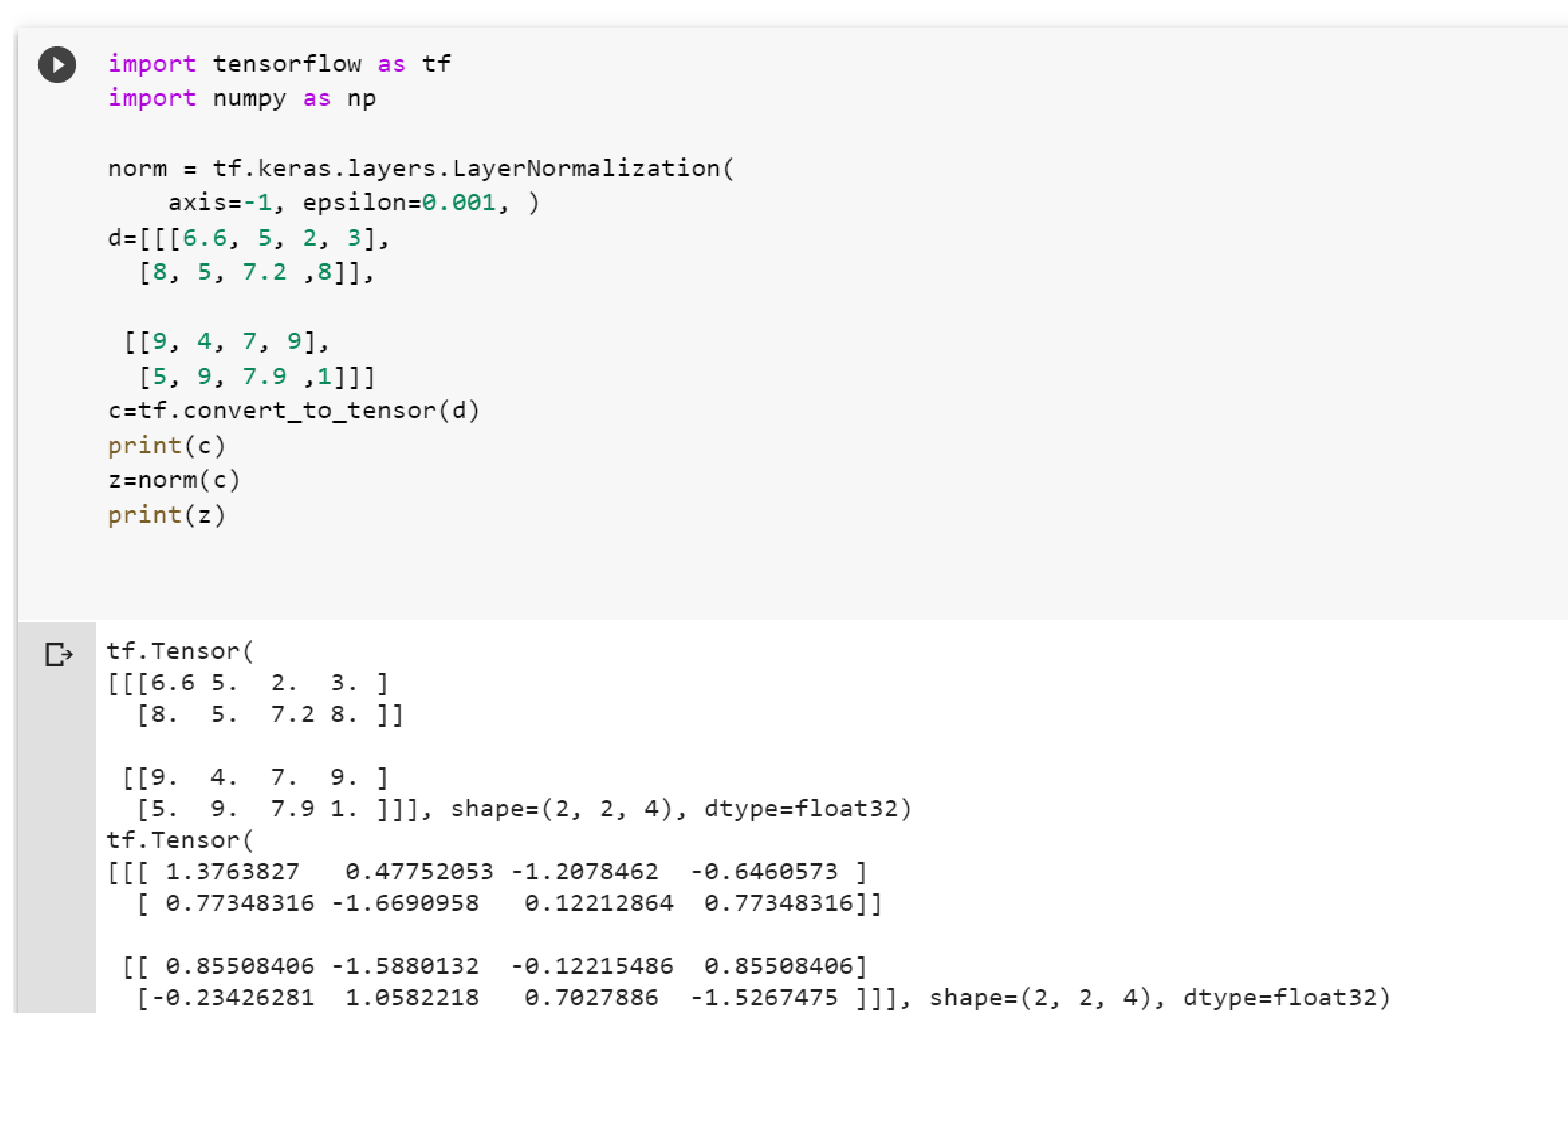

## Layer Norm also back propagates but it  appears a bit intimidating

